**Installations**

In [1]:
  !pip install transformers

     |████████████████████████████████| 675kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 15.1MB/s 
     |████████████████████████████████| 890kB 25.0MB/s 
     |████████████████████████████████| 3.8MB 31.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a8d278fe2a9781831dd8008a95296b8d8e40745aad1c430102c5ed601226d4ce
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import torch

**Downloading CoLA data**

In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=5540c0324fa4763ed81fbc7daf0e2a990e611f202f475fe4c8d59b277218825b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [5]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


**extract and tokenize data**

In [0]:
import csv
sentences=[]
labels=[]
with open("./cola_public/raw/in_domain_train.tsv") as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    for line in tsvreader:
        sentences += [line[3]]
        labels += [int(line[1])]

In [7]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base') 


In [8]:
# ici juste un tour pour voir quelle est la taille max . on visera un peu pls haut par sécurité.

max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [9]:
input_ids = []

for sent in sentences:
  encoded_dict = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict)
    

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([    0,  1541,   964,   351,    75,   907,    42,  1966,     6,   905,
         1937,     5,   220,    65,    52, 15393,     4,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])


**prepare training and validation set**

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


**create model to be finetuned**

In [12]:
from transformers import RobertaForSequenceClassification, RobertaConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

**prepare finetuning training**

In [0]:
# see https://mccormickml.com/2019/07/22/BERT-fine-tuning/

from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [17]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla K80


**train.**

In [18]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:29.
  Batch    80  of    241.    Elapsed: 0:00:57.
  Batch   120  of    241.    Elapsed: 0:01:25.
  Batch   160  of    241.    Elapsed: 0:01:53.
  Batch   200  of    241.    Elapsed: 0:02:22.
  Batch   240  of    241.    Elapsed: 0:02:50.

  Average training loss: 0.61
  Training epcoh took: 0:02:50

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.60
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:28.
  Batch    80  of    241.    Elapsed: 0:00:57.
  Batch   120  of    241.    Elapsed: 0:01:25.
  Batch   160  of    241.    Elapsed: 0:01:54.
  Batch   200  of    241.    Elapsed: 0:02:22.
  Batch   240  of    241.    Elapsed: 0:02:50.

  Average training loss: 0.49
  Training epcoh took: 0:02:51

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.42
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
 

# Gradient sanity check

In [0]:
from transformers.modeling_utils import create_position_ids_from_input_ids
import matplotlib.pyplot as plt
import numpy as np

**gradient descent on one input**

epoch 0: norm of add is 0.019196 and loss is 1.575303e-02
epoch 1: norm of add is 0.019196 and loss is 1.576185e-02
epoch 2: norm of add is 0.019196 and loss is 1.577091e-02
epoch 3: norm of add is 0.019196 and loss is 1.577973e-02
epoch 4: norm of add is 0.019196 and loss is 1.578856e-02
epoch 5: norm of add is 0.019196 and loss is 1.579762e-02
epoch 6: norm of add is 0.019196 and loss is 1.580644e-02
epoch 7: norm of add is 0.019197 and loss is 1.581550e-02
epoch 8: norm of add is 0.019197 and loss is 1.582456e-02
epoch 9: norm of add is 0.019197 and loss is 1.583362e-02
epoch 10: norm of add is 0.019198 and loss is 1.584268e-02
epoch 11: norm of add is 0.019198 and loss is 1.585174e-02
epoch 12: norm of add is 0.019199 and loss is 1.586103e-02
epoch 13: norm of add is 0.019199 and loss is 1.587009e-02
epoch 14: norm of add is 0.019200 and loss is 1.587939e-02
epoch 15: norm of add is 0.019201 and loss is 1.588845e-02
epoch 16: norm of add is 0.019201 and loss is 1.589799e-02
epoch 1

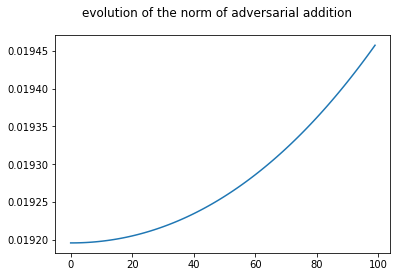

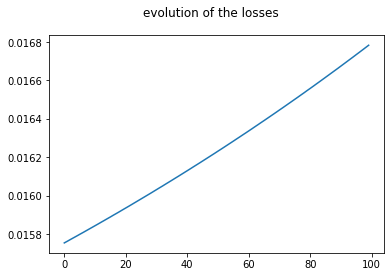

In [22]:
#batch
x = input_ids[0].unsqueeze(0).to(device)

#descent param
lr = 1e-4
n_epochs = 100

#contain results
norm_memory=np.zeros((n_epochs,))
loss_memory=np.zeros((n_epochs,))

#adversarial addition
add=torch.zeros([1,64,768], dtype=torch.float, requires_grad=True).to(device)
for j in range(64):
  for i in range(768):
    add[0,j,i]+= 1.5e-4*random.random() #j'ajoute un delta aux embedding de tous les mots de la phrase
addr=add.clone()

add.retain_grad()

#some model requirements for the calculation
padding_idx=1
input_shape = x.size()
seq_length = input_shape[1]
device = torch.device("cuda") 
position_ids = create_position_ids_from_input_ids(input_ids[0].unsqueeze(0), 1).to(device) 
token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

#model calculations:

emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x

for epoch in range(n_epochs):

  emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
  emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
  ess=list(model.roberta.embeddings.children())[1:][2](emb+add+emb2+emb3) #emb+add!
  out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

  #getting result of encoder layer of roberta
  out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
  for i in range(1,12):
    out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

  #getting result of pooler layer of roberta
  out_3nd = model.roberta.pooler(out_2nd[0])
  out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
  out_fin=out_4nd[0]

  #getting result of classifier layer of roberta
  out=model.classifier(out_fin) #this is equivalent to model(x)

  criterion=torch.nn.CrossEntropyLoss()

  loss=criterion(out,labels[0].unsqueeze(0).to(device)) 

  outgrad=loss.backward(retain_graph=True)

  print("epoch %s: norm of add is %f and loss is %e" %(epoch,torch.norm(add,2),loss))
  norm_memory[epoch]=torch.norm(add,2)
  loss_memory[epoch]= loss

  with torch.no_grad():
        add += lr * add.grad
    
  add.grad.zero_()
  
  

print("descent")
plt.plot(norm_memory)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memory)
plt.suptitle('evolution of the losses')
plt.show()


epoch 0: norm of add is 0.019244 and loss is 1.574564e-02
epoch 1: norm of add is 0.029280 and loss is 2.234268e-02
epoch 2: norm of add is 0.046964 and loss is 3.187311e-02
epoch 3: norm of add is 0.065076 and loss is 4.637551e-02
epoch 4: norm of add is 0.081236 and loss is 8.619809e-02
epoch 5: norm of add is 0.096583 and loss is 1.696088e-01
epoch 6: norm of add is 0.112024 and loss is 2.632071e-01
epoch 7: norm of add is 0.128964 and loss is 3.578524e-01
epoch 8: norm of add is 0.145789 and loss is 4.472142e-01
epoch 9: norm of add is 0.162354 and loss is 5.358887e-01
epoch 10: norm of add is 0.178730 and loss is 6.280434e-01
epoch 11: norm of add is 0.195276 and loss is 7.208393e-01
epoch 12: norm of add is 0.211151 and loss is 8.102679e-01
epoch 13: norm of add is 0.226946 and loss is 8.946142e-01
epoch 14: norm of add is 0.242123 and loss is 9.765321e-01
epoch 15: norm of add is 0.256242 and loss is 1.060954e+00
epoch 16: norm of add is 0.270198 and loss is 1.149575e+00
epoch 1

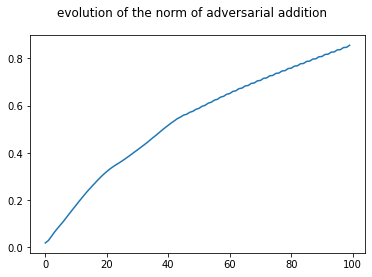

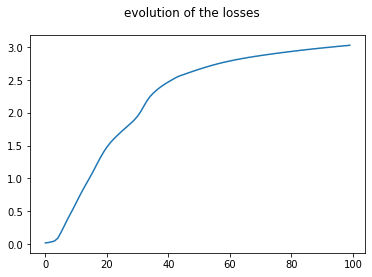

In [27]:
#batch
x = input_ids[0].unsqueeze(0).to(device)

#descent param
lr = 1e-4
n_epochs = 100

#contain results
norm_memory=np.zeros((n_epochs,))
loss_memory=np.zeros((n_epochs,))

#adversarial addition
add=torch.zeros([1,64,768], dtype=torch.float, requires_grad=True).to(device)
for j in range(64):
  for i in range(768):
    add[0,j,i]+= 1.5e-4*random.random() #j'ajoute un delta aux embedding de tous les mots de la phrase
addr=add.clone()

add.retain_grad()

#some model requirements for the calculation
padding_idx=1
input_shape = x.size()
seq_length = input_shape[1]
device = torch.device("cuda") 
position_ids = create_position_ids_from_input_ids(input_ids[0].unsqueeze(0), 1).to(device) 
token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

#model calculations:

emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x

for epoch in range(n_epochs):

  emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
  emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
  ess=list(model.roberta.embeddings.children())[1:][2](emb+add+emb2+emb3) #emb+add!
  out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

  #getting result of encoder layer of roberta
  out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
  for i in range(1,12):
    out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

  #getting result of pooler layer of roberta
  out_3nd = model.roberta.pooler(out_2nd[0])
  out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
  out_fin=out_4nd[0]

  #getting result of classifier layer of roberta
  out=model.classifier(out_fin) #this is equivalent to model(x)

  criterion=torch.nn.CrossEntropyLoss()

  loss=criterion(out,labels[0].unsqueeze(0).to(device)) 

  outgrad=loss.backward(retain_graph=True)

  print("epoch %s: norm of add is %f and loss is %e" %(epoch,torch.norm(add,2),loss))
  norm_memory[epoch]=torch.norm(add,2)
  loss_memory[epoch]= loss

  with torch.no_grad():
        add += lr * torch.sign(add.grad)
    
  add.grad.zero_()
  
  

print("descent")
plt.plot(norm_memory)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memory)
plt.suptitle('evolution of the losses')
plt.show()


epoch 0: norm of add is 0.000000 and loss is 1.575422e-02
epoch 1: norm of add is 0.000000 and loss is 1.575446e-02
epoch 2: norm of add is 0.000001 and loss is 1.575446e-02
epoch 3: norm of add is 0.000001 and loss is 1.575470e-02
epoch 4: norm of add is 0.000001 and loss is 1.575470e-02
epoch 5: norm of add is 0.000001 and loss is 1.575494e-02
epoch 6: norm of add is 0.000002 and loss is 1.575494e-02
epoch 7: norm of add is 0.000002 and loss is 1.575494e-02
epoch 8: norm of add is 0.000002 and loss is 1.575494e-02
epoch 9: norm of add is 0.000003 and loss is 1.575518e-02
epoch 10: norm of add is 0.000003 and loss is 1.575518e-02
epoch 11: norm of add is 0.000003 and loss is 1.575541e-02
epoch 12: norm of add is 0.000004 and loss is 1.575541e-02
epoch 13: norm of add is 0.000004 and loss is 1.575541e-02
epoch 14: norm of add is 0.000004 and loss is 1.575565e-02
epoch 15: norm of add is 0.000004 and loss is 1.575565e-02
epoch 16: norm of add is 0.000005 and loss is 1.575565e-02
epoch 1

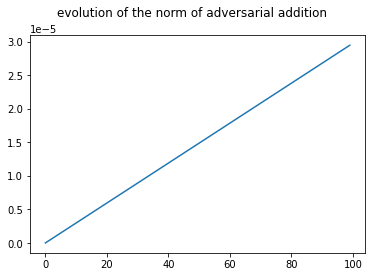

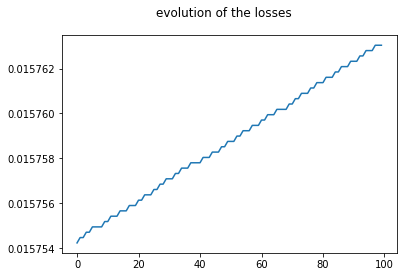

In [25]:
#batch
x = input_ids[0].unsqueeze(0).to(device)

#descent param
lr = 1e-6
n_epochs = 100

#contain results
norm_memory=np.zeros((n_epochs,))
loss_memory=np.zeros((n_epochs,))

#adversarial addition
add=torch.zeros([1,64,768], dtype=torch.float, requires_grad=True).to(device)
#for j in range(64):
#  for i in range(768):
#    add[0,j,i]+= 1.5e-4*random.random() #j'ajoute un delta aux embedding de tous les mots de la phrase
addr=add.clone()

add.retain_grad()

#some model requirements for the calculation
padding_idx=1
input_shape = x.size()
seq_length = input_shape[1]
device = torch.device("cuda") 
position_ids = create_position_ids_from_input_ids(input_ids[0].unsqueeze(0), 1).to(device) 
token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

#model calculations:

emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x

for epoch in range(n_epochs):

  emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
  emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
  ess=list(model.roberta.embeddings.children())[1:][2](emb+add+emb2+emb3) #emb+add!
  out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

  #getting result of encoder layer of roberta
  out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
  for i in range(1,12):
    out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

  #getting result of pooler layer of roberta
  out_3nd = model.roberta.pooler(out_2nd[0])
  out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
  out_fin=out_4nd[0]

  #getting result of classifier layer of roberta
  out=model.classifier(out_fin) #this is equivalent to model(x)

  criterion=torch.nn.CrossEntropyLoss()

  loss=criterion(out,labels[0].unsqueeze(0).to(device)) 

  outgrad=loss.backward(retain_graph=True)

  print("epoch %s: norm of add is %f and loss is %e" %(epoch,torch.norm(add,2),loss))
  norm_memory[epoch]=torch.norm(add,2)
  loss_memory[epoch]= loss

  with torch.no_grad():
        add += lr * add.grad
    
  add.grad.zero_()
  
  

print("descent")
plt.plot(norm_memory)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memory)
plt.suptitle('evolution of the losses')
plt.show()


epoch 0: norm of add is 0.000000 and loss is 1.575422e-02
epoch 1: norm of add is 0.000222 and loss is 1.580143e-02
epoch 2: norm of add is 0.000443 and loss is 1.584888e-02
epoch 3: norm of add is 0.000664 and loss is 1.589704e-02
epoch 4: norm of add is 0.000885 and loss is 1.594520e-02
epoch 5: norm of add is 0.001106 and loss is 1.599407e-02
epoch 6: norm of add is 0.001327 and loss is 1.604319e-02
epoch 7: norm of add is 0.001548 and loss is 1.609254e-02
epoch 8: norm of add is 0.001769 and loss is 1.614261e-02
epoch 9: norm of add is 0.001990 and loss is 1.619315e-02
epoch 10: norm of add is 0.002211 and loss is 1.624393e-02
epoch 11: norm of add is 0.002433 and loss is 1.629519e-02
epoch 12: norm of add is 0.002654 and loss is 1.634669e-02
epoch 13: norm of add is 0.002875 and loss is 1.639867e-02
epoch 14: norm of add is 0.003096 and loss is 1.645112e-02
epoch 15: norm of add is 0.003317 and loss is 1.650429e-02
epoch 16: norm of add is 0.003538 and loss is 1.655746e-02
epoch 1

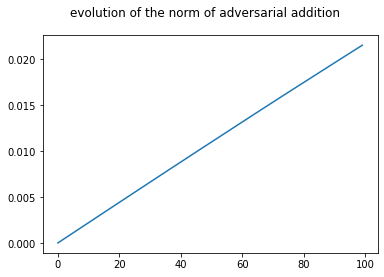

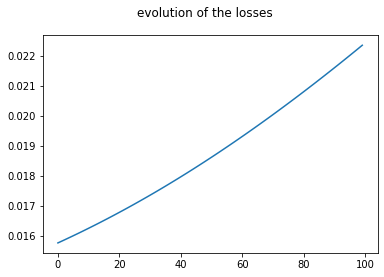

In [26]:
#batch
x = input_ids[0].unsqueeze(0).to(device)

#descent param
lr = 1e-6
n_epochs = 100

#contain results
norm_memory=np.zeros((n_epochs,))
loss_memory=np.zeros((n_epochs,))

#adversarial addition
add=torch.zeros([1,64,768], dtype=torch.float, requires_grad=True).to(device)
#for j in range(64):
#  for i in range(768):
#    add[0,j,i]+= 1.5e-4*random.random() #j'ajoute un delta aux embedding de tous les mots de la phrase
addr=add.clone()

add.retain_grad()

#some model requirements for the calculation
padding_idx=1
input_shape = x.size()
seq_length = input_shape[1]
device = torch.device("cuda") 
position_ids = create_position_ids_from_input_ids(input_ids[0].unsqueeze(0), 1).to(device) 
token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

#model calculations:

emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x

for epoch in range(n_epochs):

  emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
  emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
  ess=list(model.roberta.embeddings.children())[1:][2](emb+add+emb2+emb3) #emb+add!
  out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

  #getting result of encoder layer of roberta
  out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
  for i in range(1,12):
    out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

  #getting result of pooler layer of roberta
  out_3nd = model.roberta.pooler(out_2nd[0])
  out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
  out_fin=out_4nd[0]

  #getting result of classifier layer of roberta
  out=model.classifier(out_fin) #this is equivalent to model(x)

  criterion=torch.nn.CrossEntropyLoss()

  loss=criterion(out,labels[0].unsqueeze(0).to(device)) 

  outgrad=loss.backward(retain_graph=True)

  print("epoch %s: norm of add is %f and loss is %e" %(epoch,torch.norm(add,2),loss))
  norm_memory[epoch]=torch.norm(add,2)
  loss_memory[epoch]= loss

  with torch.no_grad():
        add += lr * torch.sign(add.grad)
    
  add.grad.zero_()
  
  

print("descent")
plt.plot(norm_memory)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memory)
plt.suptitle('evolution of the losses')
plt.show()


In [0]:


################## compare with opposit descent

addr.retain_grad()

#contain results
norm_memoryr=np.zeros((n_epochs,))
loss_memoryr=np.zeros((n_epochs,))

for epoch in range(n_epochs):

  emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
  emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
  ess=list(model.roberta.embeddings.children())[1:][2](emb+addr+emb2+emb3) #emb+add!
  out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

  #getting result of encoder layer of roberta
  out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
  for i in range(1,12):
    out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

  #getting result of pooler layer of roberta
  out_3nd = model.roberta.pooler(out_2nd[0])
  out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
  out_fin=out_4nd[0]

  #getting result of classifier layer of roberta
  out=model.classifier(out_fin) #this is equivalent to model(x)

  criterion=torch.nn.CrossEntropyLoss()

  lossr=criterion(out,labels[0].unsqueeze(0).to(device)) 

  outgrad=lossr.backward(retain_graph=True)

  norm_memoryr[epoch]=torch.norm(addr,2)
  loss_memoryr[epoch]= lossr

  with torch.no_grad():
        addr -= lr * addr.grad
    
  
  addr.grad.zero_()

print("compared to:")
plt.plot(norm_memoryr)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memoryr)
plt.suptitle('evolution of the losses')
plt.show()
    


epoch 0: norm of add is 0.019238 and loss is 3.390631e-01
epoch 1: norm of add is 0.019238 and loss is 3.390631e-01
epoch 2: norm of add is 0.019238 and loss is 3.390631e-01
epoch 3: norm of add is 0.019238 and loss is 3.390631e-01
epoch 4: norm of add is 0.019238 and loss is 3.390631e-01
epoch 5: norm of add is 0.019238 and loss is 3.390631e-01
epoch 6: norm of add is 0.019238 and loss is 3.390631e-01
epoch 7: norm of add is 0.019238 and loss is 3.390631e-01
epoch 8: norm of add is 0.019238 and loss is 3.390631e-01
epoch 9: norm of add is 0.019238 and loss is 3.390631e-01
descent


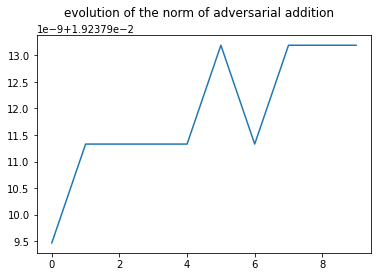

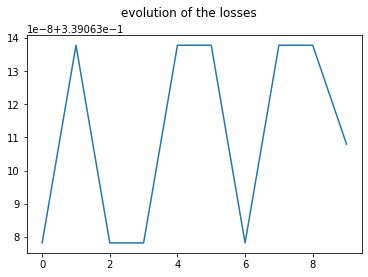

compared to:


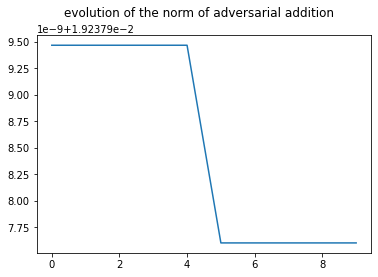

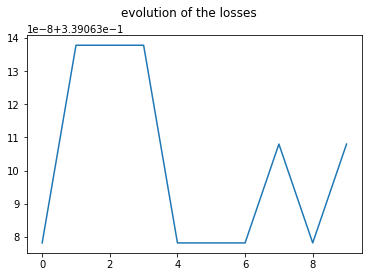

In [21]:
### another try

#batch
x = input_ids[0].unsqueeze(0).to(device)

#descent param
lr = 1e-4
n_epochs = 10

#contain results
norm_memory=np.zeros((10,))
loss_memory=np.zeros((10,))

#adversarial addition
add=torch.zeros([1,64,768], dtype=torch.float, requires_grad=True).to(device)
for j in range(64):
  for i in range(768):
    add[0,j,i]+= 1.5e-4*random.random() #j'ajoute un delta aux embedding de tous les mots de la phrase
addr=add.clone()

add.retain_grad()

#some model requirements for the calculation
padding_idx=1
input_shape = x.size()
seq_length = input_shape[1]
device = torch.device("cuda") 
position_ids = create_position_ids_from_input_ids(input_ids[0].unsqueeze(0), 1).to(device) 
token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

#model calculations:

emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x

for epoch in range(n_epochs):

  emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
  emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
  ess=list(model.roberta.embeddings.children())[1:][2](emb+add+emb2+emb3) #emb+add!
  out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

  #getting result of encoder layer of roberta
  out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
  for i in range(1,12):
    out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

  #getting result of pooler layer of roberta
  out_3nd = model.roberta.pooler(out_2nd[0])
  out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
  out_fin=out_4nd[0]

  #getting result of classifier layer of roberta
  out=model.classifier(out_fin) #this is equivalent to model(x)

  criterion=torch.nn.CrossEntropyLoss()

  loss=criterion(out,labels[0].unsqueeze(0).to(device)) 

  outgrad=loss.backward(retain_graph=True)

  print("epoch %s: norm of add is %f and loss is %e" %(epoch,torch.norm(add,2),loss))
  norm_memory[epoch]=torch.norm(add,2)
  loss_memory[epoch]= loss

  with torch.no_grad():
        add += lr * add.grad
    
  
  add.grad.zero_()

print("descent")
plt.plot(norm_memory)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memory)
plt.suptitle('evolution of the losses')
plt.show()

################## compare with opposit descent

addr.retain_grad()

#contain results
norm_memoryr=np.zeros((10,))
loss_memoryr=np.zeros((10,))

for epoch in range(n_epochs):

  emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
  emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
  ess=list(model.roberta.embeddings.children())[1:][2](emb+addr+emb2+emb3) #emb+add!
  out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

  #getting result of encoder layer of roberta
  out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
  for i in range(1,12):
    out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

  #getting result of pooler layer of roberta
  out_3nd = model.roberta.pooler(out_2nd[0])
  out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
  out_fin=out_4nd[0]

  #getting result of classifier layer of roberta
  out=model.classifier(out_fin) #this is equivalent to model(x)

  criterion=torch.nn.CrossEntropyLoss()

  lossr=criterion(out,labels[0].unsqueeze(0).to(device)) 

  outgrad=lossr.backward(retain_graph=True)

  norm_memoryr[epoch]=torch.norm(addr,2)
  loss_memoryr[epoch]= lossr

  with torch.no_grad():
        addr -= lr * addr.grad
    
  
  addr.grad.zero_()

print("compared to:")
plt.plot(norm_memoryr)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memoryr)
plt.suptitle('evolution of the losses')
plt.show()
    

**gradient descent on batch**

In [0]:
input_ids_adv=input_ids.clone()

# Combine the training inputs into a TensorDataset.
dataset_adv = TensorDataset(input_ids_adv, labels)
 
adv_size = len(dataset_adv)  
 
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 10

# For validation the order doesn't matter, so we'll just read them sequentially.
dataloader_adv = DataLoader(
            dataset_adv, # The validation samples.
            sampler = SequentialSampler(dataset_adv), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


add norms:
(0.019195761531591415, 0.019195761531591415, 0.019195761531591415)
evolution of loss during epochs:
(0.3389851748943329, 0.3389851450920105, 0.3389851450920105)


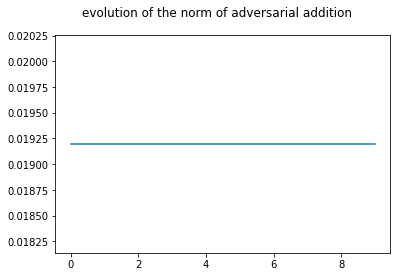

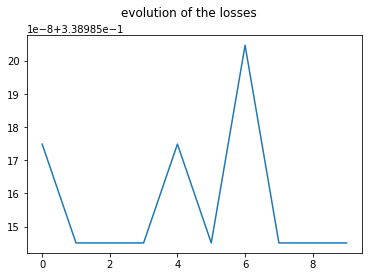

add norms:
(0.019244885072112083, 0.019244885072112083, 0.019244885072112083)
evolution of loss during epochs:
(0.4296693205833435, 0.4296693205833435, 0.42966943979263306)


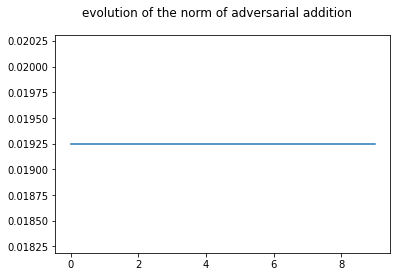

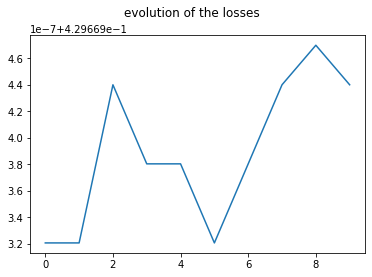

RuntimeError: ignored

In [23]:
#batch

for batch in dataloader_adv:
    
  x = batch[0].to(device)

  #descent param
  lr = 1e-2
  n_epochs = 10

  add_memory=[]
  addgrad_memory=[]
  loss_memory=[]

  #adversarial addition
  add=torch.zeros([x.size()[0],64,768], dtype=torch.float, requires_grad=True).to(device)
  for j in range(64):
    for i in range(768):
      add[0,j,i]+= 1.5e-04*random.random() #j'ajoute un delta aux embedding de tous les mots de chaque phrase

  add.retain_grad()

  #some model requirements for the calculation
  padding_idx=1
  input_shape = x.size()
  seq_length = input_shape[1]
  device = torch.device("cuda") 
  position_ids = create_position_ids_from_input_ids(batch[0], 1).to(device) 
  token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

  #model calculations:

  emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x

  for epoch in range(n_epochs):

    emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
    emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
    ess=list(model.roberta.embeddings.children())[1:][2](emb+add+emb2+emb3) #emb+add!
    out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

    #getting result of encoder layer of roberta
    out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
    for i in range(1,12):
      out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

    #getting result of pooler layer of roberta
    out_3nd = model.roberta.pooler(out_2nd[0])
    out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
    out_fin=out_4nd[0]

    #getting result of classifier layer of roberta
    out=model.classifier(out_fin) #this is equivalent to model(x)

    criterion=torch.nn.CrossEntropyLoss()
    loss=criterion(out,batch[1].to(device)) 
    outgrad=loss.backward(retain_graph=True)

    #just memorize experiment
    add_memory+=[add]
    addgrad_memory+=[add.grad] #check if not vanishing
    loss_memory+=[loss]

    with torch.no_grad():
          add += lr * add.grad
      
    add.grad.zero_()


  print('add norms:') #hopefully constant
  print((float(torch.norm(add_memory[0],2)),float(torch.norm(add_memory[int(n_epochs/2)],2)),float(torch.norm(add_memory[-1],2))))
  print('evolution of loss during epochs:') #hopefully increasing
  print((float(loss_memory[0]),float(loss_memory[int(n_epochs/2)]),float(loss_memory[-1])))

  for a in range(n_epochs):
    add_memory[a]=float(torch.norm(add_memory[a],2))
  plt.plot(add_memory)
  plt.suptitle('evolution of the norm of adversarial addition')
  plt.axis()
  plt.show()
  plt.plot(loss_memory)
  plt.suptitle('evolution of the losses')
  plt.show()


# loss of our model on adversarial dataset

In [0]:
input_ids_adv=input_ids.clone()

# Combine the training inputs into a TensorDataset.
dataset_adv = TensorDataset(input_ids_adv, labels) 
 
# Calculate the number of samples to include in each set.
adv_size = int(0.015 * len(dataset))
adv_size2 = len(dataset_adv) - adv_size

# Divide the dataset by randomly selecting samples.
dataset_adv, dataset_adv2 = random_split(dataset, [adv_size, adv_size2])
 
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 10

# For validation the order doesn't matter, so we'll just read them sequentially.
dataloader_adv = DataLoader(
            dataset_adv, # The validation samples.
            sampler = SequentialSampler(dataset_adv), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [0]:
#PREPARE ADVERSARIAL DATASET WITH GRADIENT DESCENT

batch_size = 10
add_data=[] #contains each adversarial addition for each batch

for batch in dataloader_adv:
    
  x = batch[0].to(device)

  #descent param
  lr = 1e-2
  n_epochs = 10

  #adversarial addition
  add=torch.zeros([x.size()[0],64,768], dtype=torch.float, requires_grad=True).to(device)
  for j in range(64):
    for i in range(768):
      add[0,j,i]+= 1.5e-04*random.random() #j'ajoute un delta aux embedding de tous les mots de chaque phrase

  add.retain_grad()

  #some model requirements for the calculation
  padding_idx=1
  input_shape = x.size()
  seq_length = input_shape[1]
  device = torch.device("cuda") 
  position_ids = create_position_ids_from_input_ids(batch[0], 1).to(device) 
  token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

  #model calculations:

  emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x

  for epoch in range(n_epochs):

    emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
    emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
    ess=list(model.roberta.embeddings.children())[1:][2](emb+add+emb2+emb3) #emb+add!
    out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

    #getting result of encoder layer of roberta
    out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
    for i in range(1,12):
      out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

    #getting result of pooler layer of roberta
    out_3nd = model.roberta.pooler(out_2nd[0])
    out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
    out_fin=out_4nd[0]

    #getting result of classifier layer of roberta
    out=model.classifier(out_fin) #this is equivalent to model(x)

    criterion=torch.nn.CrossEntropyLoss()
    loss=criterion(out,batch[1].to(device)) 
    outgrad=loss.backward(retain_graph=True)

    with torch.no_grad():
          add += lr * add.grad
      
    add.grad.zero_()


  add_data+=[add]
  if len(add_data)%10==0:
    print(len(add_data))


In [0]:
len(add_data)

In [0]:
#COMPARE VALIDATION OF MODEL ON INITIAL DATASET AND ADVERSARIAL DATASET
 
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Measure the total training time for the whole run.
total_t0 = time.time()


# ========================================
#               Validation
# ========================================
# After the completion of each training epoch, measure our performance on
# our validation set.

print("")
print("Running Validation...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

# Tracking variables  
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0

total_eval_accuracy_adv = 0
total_eval_loss_adv = 0

incr=0
# Evaluate data for one epoch
for batch in dataloader_adv:
    
    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)

    b_input_ids_adv = batch[0].to(device)
    b_labels_adv = batch[1].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        (loss, logits) = model(b_input_ids, 
                                token_type_ids=None, 
                                labels=b_labels)
        
        ################ beginning of loss calculation on adversarial dataset

        #batch
        x = b_input_ids_adv

        #some model requirements for the calculation
        padding_idx=1
        input_shape = x.size()
        seq_length = input_shape[1]
        device = torch.device("cuda") 
        position_ids = create_position_ids_from_input_ids(batch[0], 1).to(device) #b_input_ids_adv ?
        token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

        #model calculations:
        emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x
        emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
        emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
        ess=list(model.roberta.embeddings.children())[1:][2](emb+add_data[incr]+emb2+emb3) #emb+add!
        out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

        #getting result of encoder layer of roberta
        out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
        for i in range(1,12):
          out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

        #getting result of pooler layer of roberta
        out_3nd = model.roberta.pooler(out_2nd[0])
        out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
        out_fin=out_4nd[0]

        #getting result of classifier layer of roberta
        out=model.classifier(out_fin) #this is equivalent to model(x)

        criterion=torch.nn.CrossEntropyLoss()
        loss_adv=criterion(out,b_labels_adv) 

        logits_adv = out

        ################ end of loss calculation on adversarial dataset
        
    # Accumulate the validation loss.
    total_eval_loss += loss.item()
    total_eval_loss_adv += loss_adv.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    logits_adv = logits_adv.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)

    total_eval_accuracy_adv += flat_accuracy(logits_adv, label_ids)

    incr+=1
    

# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy / len(dataloader_adv)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
avg_val_accuracy_adv = total_eval_accuracy_adv / len(dataloader_adv)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy_adv))

# Calculate the average loss over all of the batches.
avg_val_loss = total_eval_loss / len(dataloader_adv)
avg_val_loss_adv = total_eval_loss_adv / len(dataloader_adv)

# Measure how long the validation run took.
validation_time = format_time(time.time() - t0)

print("  Validation took: {:}".format(validation_time))
print("  Validation Loss: {0:.2f}".format(avg_val_loss))
print(" Valid. Accur.: {:}".format(avg_val_accuracy))
print("  Validation Loss: {0:.2f}".format(avg_val_loss_adv))
print(" Valid. Accur.: {:}".format(avg_val_accuracy_adv))

print("")
